# PCA + k-Means on ERA5 Data

## Results

- Data preprocessing takes ~10min
- PCA with 500 PCs takes ~8.5min
- PCA (reduced PCs), Transforming and clustering (2 x k-Means) takes ~3min
- kPCA with 500 PCs takes ~6.5min
- kPCA (reduced PCs), Transforming and clustering (2 x k-Means) takes ~7.5min
- PCA:
  - N_pcs=1 cover 0.2 of the variance
  - N_pcs=2 cover 0.3 of the variance
  - N_pcs=3 cover 0.4 of the variance
  - N_pcs=5 cover 0.5 of the variance
  - N_pcs=10 cover 0.6 of the variance
  - N_pcs=24 cover 0.7 of the variance
  - N_pcs=80 cover 0.8 of the variance
  - N_pcs=171 cover 0.85 of the variance
  - N_pcs=421 cover 0.9 of the variance
- kPCA:
  - N_pcs=1 cover 0.3 of the variance
  - N_pcs=2 cover 0.4 of the variance
  - N_pcs=4 cover 0.5 of the variance
  - N_pcs=6 cover 0.6 of the variance
  - N_pcs=13 cover 0.7 of the variance
  - N_pcs=32 cover 0.8 of the variance
  - N_pcs=103 cover 0.9 of the variance


In [88]:
%load_ext autoreload
%autoreload 2
import pathlib
import joblib

import sklearn.cluster
import sklearn.decomposition
import sklearn.preprocessing
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr


import a6
import a6.plotting._colors as _colors

a6.utils.logging.create_logger(
    global_rank=0,
    local_rank=0,
    verbose=False,
)

path = pathlib.Path(
    "/p/project1/deepacf/emmerich1/data/ecmwf_era5/era5_pl_1964_2023_12.nc"
)
plots = pathlib.Path("/p/project1/deepacf/emmerich1/plots/paper-1")
pca_dir = pathlib.Path("/p/scratch/deepacf/emmerich1/pca")
kmeans_dir = pathlib.Path("/p/project1/deepacf/emmerich1/data/kmeans")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
%%time

ds = xr.open_dataset(path)

coordinates = a6.datasets.coordinates.Coordinates()
variables = a6.datasets.variables.Model()

ds

CPU times: user 486 ms, sys: 108 ms, total: 594 ms
Wall time: 3.04 s


<xarray.Dataset>
Dimensions:    (longitude: 221, latitude: 141, level: 5, time: 21826)
Coordinates:
  * longitude  (longitude) float32 -25.0 -24.75 -24.5 -24.25 ... 29.5 29.75 30.0
  * latitude   (latitude) float32 70.0 69.75 69.5 69.25 ... 35.5 35.25 35.0
  * level      (level) int32 300 500 700 850 950
  * time       (time) datetime64[ns] 1964-01-01T12:00:00 ... 2023-10-03T12:00:00
Data variables:
    z          (time, level, latitude, longitude) float32 ...
    r          (time, level, latitude, longitude) float32 ...
    t          (time, level, latitude, longitude) float32 ...
    u          (time, level, latitude, longitude) float32 ...
    v          (time, level, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-10-06 17:05:15 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [3]:
%%time

masked = a6.datasets.methods.mask.set_nans_to_mean(ds, coordinates=coordinates)
data = (
    (
        a6.features.methods.weighting.weight_by_latitudes(
            latitudes=coordinates.latitude,
            use_sqrt=True,
        )
        >> a6.features.methods.reshape.xarray.reshape_spatio_temporal_data(
            # Set to None to avoid memory excess in function
            time_coordinate=None,
        )
        >> a6.features.methods.standardization.normalize_features()
    )
    .apply_to(masked)
    .compute()
)

del masked
data.shape

RANK 0 (LOCAL 0) - INFO - 2024-05-22 17:11:45 - 0:01:33 - Masking <xarray.DataArray ()>
                                                          array(98) NaNs in data set <xarray.Dataset>
                                                          Dimensions:    (longitude: 221, latitude: 141, level: 5, time: 21826)
                                                          Coordinates:
                                                            * longitude  (longitude) float32 -25.0 -24.75 -24.5 -24.25 ... 29.5 29.75 30.0
                                                            * latitude   (latitude) float32 70.0 69.75 69.5 69.25 ... 35.5 35.25 35.0
                                                            * level      (level) int32 300 500 700 850 950
                                                            * time       (time) datetime64[ns] 1964-01-01T12:00:00 ... 2023-10-03T12:00:00
                                                          Data variables:
                  

CPU times: user 7min 55s, sys: 1min 45s, total: 9min 41s
Wall time: 9min 52s


(21826, 779025)

In [99]:
%%time
preprocessed_data_path = pathlib.Path(
    "/p/project1/deepacf/emmerich1/data/ecmwf_era5/era5_pl_1964_2023_12_preprocessed_for_pca.nc"
)

# data.to_netcdf(preprocessed_data_path)
# del data

data = xr.open_dataset(preprocessed_data_path).to_dataarray().values[0]
data.shape

CPU times: user 11 s, sys: 35.2 s, total: 46.2 s
Wall time: 46.6 s


(21826, 779025)

In [3]:
%%time
pca_path = pca_dir / "pca_500_pcs.joblib"

# pca = sklearn.decomposition.PCA(n_components=500).fit(data)
# joblib.dump(pca, pca_path)

pca = joblib.load(pca_path)

cum_evr = np.cumsum(pca.explained_variance_ratio_)

CPU times: user 150 ms, sys: 548 ms, total: 698 ms
Wall time: 885 ms


In [6]:
cum_evr[5]

0.5268544

N_pcs=0 cover 0.0 of the variance
N_pcs=0 cover 0.1 of the variance
N_pcs=1 cover 0.2 of the variance
N_pcs=2 cover 0.30000000000000004 of the variance
N_pcs=3 cover 0.4 of the variance
N_pcs=5 cover 0.5 of the variance
N_pcs=10 cover 0.6000000000000001 of the variance
N_pcs=24 cover 0.7000000000000001 of the variance
N_pcs=80 cover 0.8 of the variance
N_pcs=421 cover 0.9 of the variance
CPU times: user 1h 24min 38s, sys: 36min 43s, total: 2h 1min 22s
Wall time: 2min 53s


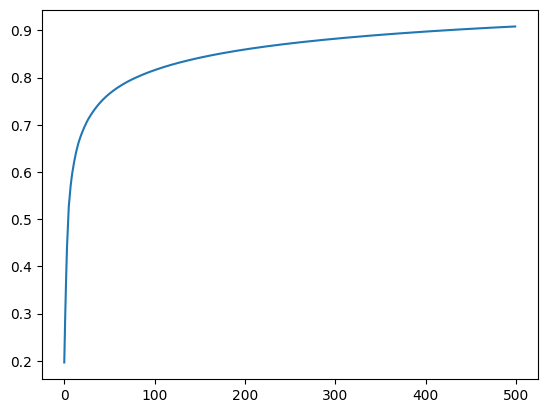

In [7]:
%%time

plt.plot(list(range(pca.n_components_)), cum_evr)
for var in np.arange(0, 1.0, 0.1):
    n_pcs = np.where(cum_evr > var)[0][0]
    print(f"N_pcs={n_pcs} cover {var} of the variance")
n_pcs = np.where(cum_evr > 0.80)[0][0]

transformed = sklearn.decomposition.PCA(n_components=n_pcs).fit_transform(data)
transformed = sklearn.preprocessing.StandardScaler().fit_transform(transformed)

kmeans_pca_40 = sklearn.cluster.KMeans(n_clusters=40).fit(transformed)
kmeans_pca_30 = sklearn.cluster.KMeans(n_clusters=30).fit(transformed)

kmeans_pca_40_labels = kmeans_pca_40.labels_
kmeans_pca_30_labels = kmeans_pca_30.labels_

In [8]:
%%time
joblib.dump(kmeans_pca_40, kmeans_dir / f"kmeans_pca_n_pcs_{n_pcs}_k_40.joblib")
joblib.dump(kmeans_pca_30, kmeans_dir / f"kmeans_pca_n_pcs_{n_pcs}_k_30.joblib")

del pca
del transformed
del kmeans_pca_40
del kmeans_pca_30

CPU times: user 520 µs, sys: 6.2 ms, total: 6.72 ms
Wall time: 32.6 ms


Kernel PCA: Gaussian radial basis function with $\sigma = 200$ (see http://dx.doi.org/10.1016/j.procs.2011.08.043)

In [25]:
%%time
kpca_path = pca_dir / "kpca_500_pcs.joblib"

kpca = sklearn.decomposition.KernelPCA(
    n_components=500, kernel="rbf", gamma=1 / 200
).fit(data)
# joblib.dump(kpca, kpca_path)

# kpca = joblib.load(kpca_path)

cum_evr = np.cumsum(kpca.eigenvalues_ / np.sum(kpca.eigenvalues_))

CPU times: user 2h 11min 22s, sys: 27min 20s, total: 2h 38min 43s
Wall time: 5min 2s


In [ ]:
%%time
plt.plot(list(range(len(kpca.eigenvalues_))), cum_evr)
for var in np.arange(0, 1.0, 0.1):
    n_pcs = np.where(cum_evr > var)[0][0]
    print(f"N_pcs={n_pcs} cover {var} of the variance")
n_pcs = np.where(cum_evr > 0.80)[0][0]

transformed = sklearn.decomposition.KernelPCA(n_components=n_pcs).fit_transform(
    data
)
transformed = sklearn.preprocessing.StandardScaler().fit_transform(transformed)

kmeans_kpca_40 = sklearn.cluster.KMeans(n_clusters=40).fit(transformed)
kmeans_kpca_30 = sklearn.cluster.KMeans(n_clusters=30).fit(transformed)

kmeans_kpca_40_labels = kmeans_kpca_40.labels_
kmeans_kpca_30_labels = kmeans_kpca_30.labels_

In [11]:
%%time

joblib.dump(
    kmeans_kpca_40, kmeans_dir / f"kmeans_kpca_n_pcs_{n_pcs}_k_40.joblib"
)
joblib.dump(
    kmeans_kpca_30, kmeans_dir / f"kmeans_kpca_n_pcs_{n_pcs}_k_30.joblib"
)

del kpca
del transformed
del kmeans_kpca_40
del kmeans_kpca_30

CPU times: user 1.57 ms, sys: 172 ms, total: 174 ms
Wall time: 205 ms


In [54]:
%%time

ds = xr.open_dataset(path)

# Add +1 to be conform to the GWL labels
kmeans_pca_40 = joblib.load(kmeans_dir / "kmeans_pca_n_pcs_6_k_40.joblib")
kmeans_pca_30 = joblib.load(kmeans_dir / "kmeans_pca_n_pcs_6_k_30.joblib")
kmeans_pca_40_labels = kmeans_pca_40.labels_ + 1
kmeans_pca_30_labels = kmeans_pca_30.labels_ + 1

# kmeans_kpca_40 = joblib.load(
#     kmeans_dir / "kmeans_kpca_n_pcs_32_k_40.joblib"
# )
# kmeans_kpca_30 = joblib.load(
#     kmeans_dir / "kmeans_kpca_n_pcs_32_k_30.joblib"
# )
# kmeans_kpca_40_labels = kmeans_kpca_40.labels_ + 1
# kmeans_kpca_30_labels = kmeans_kpca_30.labels_ + 1

# Need to convert dates to YYYY-MM-DD to be conform with GWL dataset time stamps.
times = a6.utils.times.time_steps_as_dates(ds, coordinates=coordinates)

results = xr.Dataset(
    data_vars={
        "PCA": (
            ["time", "k"],
            list(zip(kmeans_pca_30_labels, kmeans_pca_40_labels)),
        ),
        # "kPCA": (
        #     ["time", "k"],
        #     list(zip(kmeans_kpca_30_labels, kmeans_kpca_40_labels)),
        # ),
    },
    coords={
        "time": times,
        "k": [30, 40],
    },
    attrs={
        "description": "Resulting LSWR labels from K-Means clustering on PCA and kernel PCA of the ERA5 data (1964-2023)",
    },
)
results.to_netcdf(
    "/p/project1/deepacf/emmerich1/data/pca_kpca_kmeans_lswrs_30_40.nc"
)
results

CPU times: user 123 ms, sys: 10.2 ms, total: 133 ms
Wall time: 321 ms


<xarray.Dataset>
Dimensions:  (time: 21826, k: 2)
Coordinates:
  * time     (time) datetime64[ns] 1964-01-01 1964-01-02 ... 2023-10-03
  * k        (k) int64 30 40
Data variables:
    PCA      (time, k) int32 15 27 11 27 24 40 24 20 11 ... 10 9 10 9 2 9 2 28
Attributes:
    description:  Resulting LSWR labels from K-Means clustering on PCA and ke...

## Plotting

In [146]:
import matplotlib.ticker
import string
import matplotlib as mpl
import matplotlib.pyplot as plt

alphabet = list(string.ascii_lowercase)

results = xr.open_dataset(
    "/p/project1/deepacf/emmerich1/data/pca_kpca_kmeans_lswrs_30_40.nc"
)

n_lswr_categories = 30
results_pca_kmeans = results.sel(k=n_lswr_categories)
gwl = xr.open_dataset(
    "/p/home/jusers/emmerich1/juwels/code/a6/src/tests/data/gwl.nc"
)
dcv2_k = 14

# NOTE: Uncomment to save dcv2 to disk, or read from disk
# dcv2 = torch.load(
#    f "/p/project1/deepacf/emmerich1/dcv2/multi-level-all-fields-1964-2023-1200-epochs-k-{dcv2_k}/epoch-799-assignments.pt",
#     map_location=torch.device("cpu"),
# )
# dcv2 = xr.DataArray(
#     # Need to add +1 to be conform with GWL labels
#     dcv2.numpy()[0] + 1,
#     name="DCv2",
#     coords={"time": results["time"]},
#     dims=["time"],
# )
# dcv2.to_netcdf("/p/project1/deepacf/emmerich1/data/dcv2-lswrs.nc")

dcv2 = xr.open_dataset("/p/project1/deepacf/emmerich1/data/dcv2-lswrs.nc")[
    "DCv2"
]

lswrs = [dcv2, results_pca_kmeans["PCA"], gwl["GWL"]]


# Set ggplot styles and update Matplotlib with them.
def grey_background(ax):
    # Give plot a gray background like ggplot.
    ax.set_facecolor("#EBEBEB")
    # Remove border around plot.
    [ax.spines[side].set_visible(False) for side in ax.spines]


def plot_grid_with_grey_background(
    ax, minor_ticks_x: int = 0, minor_ticks_y: int = 0
):
    grey_background(ax)

    ax.grid(which="major", color="white", linewidth=1)
    # Show the minor ticks and grid.
    ax.minorticks_on()

    if minor_ticks_x > 0:
        ax.xaxis.grid(which="minor", color="white", linewidth=0.5)
        # Now hide the minor ticks (but leave the gridlines).
        ax.tick_params(axis="x", which="minor", bottom=False, left=False)
        # Only show minor gridlines once in between major gridlines.
        ax.xaxis.set_minor_locator(
            matplotlib.ticker.AutoMinorLocator(minor_ticks_x + 1)
        )

    if minor_ticks_y > 0:
        ax.yaxis.grid(which="minor", color="white", linewidth=0.5)
        ax.tick_params(axis="y", which="minor", bottom=False, left=False)
        ax.yaxis.set_minor_locator(
            matplotlib.ticker.AutoMinorLocator(minor_ticks_y + 1)
        )

In [147]:
np.unique(dcv2.data)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [148]:
pca = joblib.load(pca_dir / "pca_500_pcs.joblib")
pca_cum_evr = np.cumsum(pca.explained_variance_ratio_)

In [149]:
gwl.attrs

{'1': 'XXAAT',
 '2': 'NOAAT',
 '3': 'SOAAT',
 '4': 'SWAAT',
 '5': 'NWAAT',
 '6': 'XXAAF',
 '7': 'NOAAF',
 '8': 'SOAAF',
 '9': 'SWAAF',
 '10': 'NWAAF',
 '11': 'XXAZT',
 '12': 'NOAZT',
 '13': 'SOAZT',
 '14': 'SWAZT',
 '15': 'NWAZT',
 '16': 'XXAZF',
 '17': 'NOAZF',
 '18': 'SOAZF',
 '19': 'SWAZF',
 '20': 'NWAZF',
 '21': 'XXZAT',
 '22': 'NOZAT',
 '23': 'SOZAT',
 '24': 'SWZAT',
 '25': 'NWZAT',
 '26': 'XXZAF',
 '27': 'NOZAF',
 '28': 'SOZAF',
 '29': 'SWZAF',
 '30': 'NWZAF',
 '31': 'XXZZT',
 '32': 'NOZZT',
 '33': 'SOZZT',
 '34': 'SWZZT',
 '35': 'NWZZT',
 '36': 'XXZZF',
 '37': 'NOZZF',
 '38': 'SOZZF',
 '39': 'SWZZF',
 '40': 'NWZZF'}

In [150]:
gwl_labels_map = {int(k): v for k, v in gwl.attrs.items()}
gwl_labels = list(gwl_labels_map.values())
gwl_labels_map, gwl_labels

({1: 'XXAAT',
  2: 'NOAAT',
  3: 'SOAAT',
  4: 'SWAAT',
  5: 'NWAAT',
  6: 'XXAAF',
  7: 'NOAAF',
  8: 'SOAAF',
  9: 'SWAAF',
  10: 'NWAAF',
  11: 'XXAZT',
  12: 'NOAZT',
  13: 'SOAZT',
  14: 'SWAZT',
  15: 'NWAZT',
  16: 'XXAZF',
  17: 'NOAZF',
  18: 'SOAZF',
  19: 'SWAZF',
  20: 'NWAZF',
  21: 'XXZAT',
  22: 'NOZAT',
  23: 'SOZAT',
  24: 'SWZAT',
  25: 'NWZAT',
  26: 'XXZAF',
  27: 'NOZAF',
  28: 'SOZAF',
  29: 'SWZAF',
  30: 'NWZAF',
  31: 'XXZZT',
  32: 'NOZZT',
  33: 'SOZZT',
  34: 'SWZZT',
  35: 'NWZZT',
  36: 'XXZZF',
  37: 'NOZZF',
  38: 'SOZZF',
  39: 'SWZZF',
  40: 'NWZZF'},
 ['XXAAT',
  'NOAAT',
  'SOAAT',
  'SWAAT',
  'NWAAT',
  'XXAAF',
  'NOAAF',
  'SOAAF',
  'SWAAF',
  'NWAAF',
  'XXAZT',
  'NOAZT',
  'SOAZT',
  'SWAZT',
  'NWAZT',
  'XXAZF',
  'NOAZF',
  'SOAZF',
  'SWAZF',
  'NWAZF',
  'XXZAT',
  'NOZAT',
  'SOZAT',
  'SWZAT',
  'NWZAT',
  'XXZAF',
  'NOZAF',
  'SOZAF',
  'SWZAF',
  'NWZAF',
  'XXZZT',
  'NOZZT',
  'SOZZT',
  'SWZZT',
  'NWZZT',
  'XXZZF',
  'NOZZF',
 

## Explained Variance Ratio Plots

0.5487465858459473 EVR covered by 6 PCS
CPU times: user 1.54 s, sys: 494 ms, total: 2.03 s
Wall time: 1.29 s


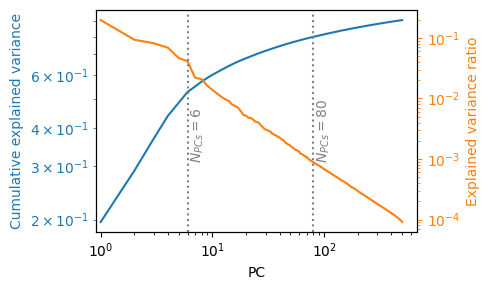

In [93]:
%%time

plt.rcParams["axes.axisbelow"] = True

fig, ax1 = plt.subplots(figsize=(5, 3))

ax1.set_xlabel("PC")

x = list(range(1, pca.n_components + 1))

# Plot cumulative variance on first axis
ax1_color = "tab:blue"
ax1.set_ylabel("Cumulative explained variance", color=ax1_color)
ax1.plot(x, pca_cum_evr, color=ax1_color, linestyle="-", label="PCA")

# Create right axis.
ax2 = ax1.twinx()

# Plot the explained variance ratios.
ax2_color = "tab:orange"
ax2.set_ylabel("Explained variance ratio", color=ax2_color)
ax2.plot(
    x,
    pca.explained_variance_ratio_,
    color=ax2_color,
    # linestyle="--",
    label="",
)

for ax, color, log_scale_y in [(ax1, ax1_color, True), (ax2, ax2_color, True)]:
    # Set log scale.
    if log_scale_y:
        ax.set(xscale="log", yscale="log")
    else:
        ax.set(xscale="log")
    # Set left xlim such that the first tick disappears.
    ax.set_xlim(0.91, None)
    # Color the ticks.
    ax.tick_params(axis="y", colors=color, which="both")


# Plot vertical line indicating variance excess.
variance = 0.8
for cum_evr, title in [
    (pca_cum_evr, ""),
]:
    n_pcs = np.where(cum_evr > variance)[0][0]
    # Dashed line indicating the threshold.
    ax2.axvline(
        n_pcs,
        ymin=0,
        ymax=1.1,
        linestyle=":",
        color="grey",
    )
    ax2.text(
        1.04 * n_pcs,
        0.001,
        f"$N_{{PCs}} = {n_pcs}${f' ({title})' if title else ''}",
        rotation=90,
        color="grey",
    )

for n_pcs, title in [
    (6, ""),
]:
    # Dashed line indicating the threshold.
    ax2.axvline(
        n_pcs,
        ymin=0,
        ymax=1.1,
        linestyle=":",
        color="grey",
    )
    ax2.text(
        1.04 * n_pcs,
        0.001,
        f"$N_{{PCs}} = {n_pcs}${f' ({title})' if title else ''}",
        rotation=90,
        color="grey",
    )
    print(f"{pca_cum_evr[n_pcs]} EVR covered by {n_pcs} PCS")
# ax2.legend()
# grey_background(ax1)
# grey_background(ax2)
fig.tight_layout()

plt.savefig(plots / "explained-variance-pca.pdf", bbox_inches="tight")

## Sum of squared distances experiment

In [94]:
ssds_pca = joblib.load(plots / "../../data/scree-test-results-pca.dict")

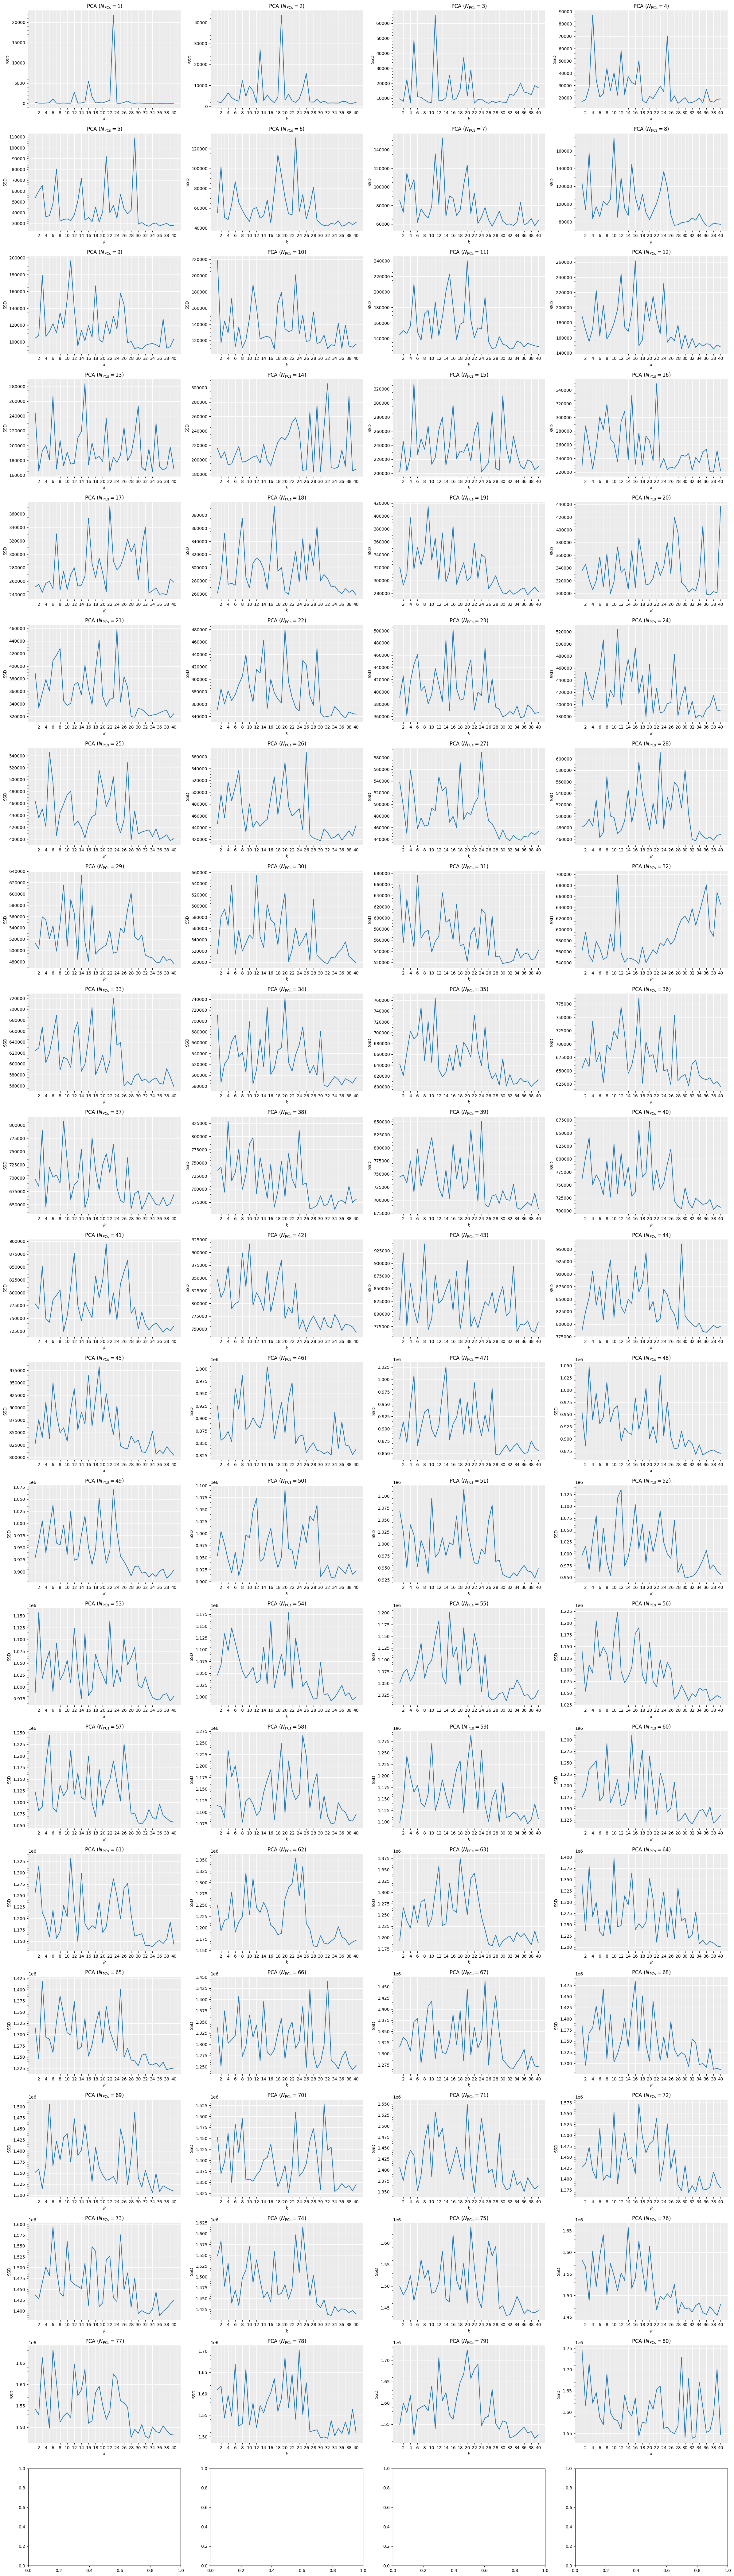

In [117]:
def plot_scree_test_results(ssds, method: str):
    ks = range(1, len(ssds[2]) + 1)

    ncols = 4
    nrows = (len(ssds) // ncols) + 1
    fig, axs = plt.subplots(
        figsize=(6 * ncols, 4 * nrows), nrows=nrows, ncols=ncols
    )

    axs_flat = axs.flatten()
    for i, (n_pcs, ssd) in enumerate(ssds.items()):
        ax = axs_flat[i]
        ax.plot(
            ks,
            list(ssd.values()),
            c="tab:blue",
            # linestyle="-",
            # marker="o",
        )
        ax.set_title(rf"{method.upper()} $(N_{{\mathrm{{PCs}}}} = {n_pcs})$")

        ax.set_xlabel(r"$k$")
        ax.set_xticks(ks[1::2])
        ax.set_xticklabels([str(k) for k in ks[1::2]])
        ax.set_ylabel("SSD")
        plot_grid_with_grey_background(ax, minor_ticks_x=1)

    fig.tight_layout()
    # plt.savefig(plots / f"kmeans-scree-test-{method}.pdf", bbox_inches="tight")


plot_scree_test_results(ssds=ssds_pca, method="pca")

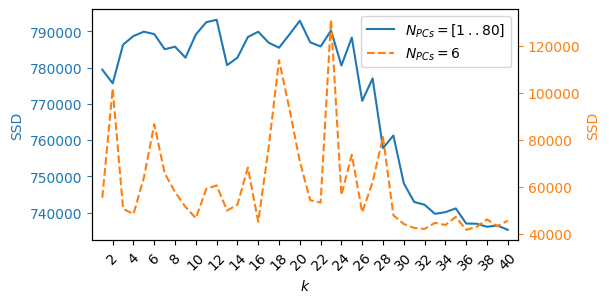

In [95]:
def plot_scree_test_results_sum_of_ssds(ssds):
    axis1_color = "tab:blue"
    axis2_color = "tab:orange"

    ks = range(1, len(ssds[2]) + 1)

    fig, ax = plt.subplots(figsize=(5.5, 3))
    values = np.array([0.0 for _ in ks])
    for ssd in ssds.values():
        values += np.array(list(ssd.values()))

    values /= len(ssds.values())

    left = ax.plot(
        ks,
        values,
        c=axis1_color,
        # linestyle="-",
        # marker="o",
        label="$N_{PCs} = [1\,..80]$",
    )

    ax2 = ax.twinx()
    ssds_6_pcs = np.array(list(ssds[6].values()))
    right = ax2.plot(
        ks,
        ssds_6_pcs,
        c=axis2_color,
        label="$N_{PCs} = 6$",
        linestyle="--",
    )

    # added these three lines
    lines = left + right
    labels = [l.get_label() for l in lines]
    ax.legend(lines, labels, loc="upper right")

    ax.set_xlabel(r"$k$")
    ax.set_xticks(ks[1::2])
    ax.set_xticklabels([str(k) for k in ks[1::2]], rotation=45)
    ax.set_ylabel("SSD", color=axis1_color)
    ax2.set_ylabel("SSD", color=axis2_color)
    ax.tick_params(axis="y", colors=axis1_color, which="both")
    ax2.tick_params(axis="y", colors=axis2_color, which="both")

    ax.set_xlim(0, 41)
    # plot_grid_with_grey_background(ax, minor_ticks_x=1)

    # fig.tight_layout()
    plt.savefig(
        plots / f"kmeans-scree-test-pca-sum-of-ssds.pdf", bbox_inches="tight"
    )


plot_scree_test_results_sum_of_ssds(ssds=ssds_pca)

In [26]:
ds

<xarray.Dataset>
Dimensions:    (longitude: 221, latitude: 141, level: 5, time: 21826)
Coordinates:
  * longitude  (longitude) float32 -25.0 -24.75 -24.5 -24.25 ... 29.5 29.75 30.0
  * latitude   (latitude) float32 70.0 69.75 69.5 69.25 ... 35.5 35.25 35.0
  * level      (level) int32 300 500 700 850 950
  * time       (time) datetime64[ns] 1964-01-01T12:00:00 ... 2023-10-03T12:00:00
Data variables:
    z          (time, level, latitude, longitude) float32 ...
    r          (time, level, latitude, longitude) float32 ...
    t          (time, level, latitude, longitude) float32 ...
    u          (time, level, latitude, longitude) float32 ...
    v          (time, level, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-10-06 17:05:15 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

## PC scores and EOFs for PC 1-6

In [102]:
%%time

shape = (len(ds[coordinates.latitude]), len(ds[coordinates.longitude]))
print(shape)
size = shape[0] * shape[1]
level_index = 1
n_pcs = 6
pcs_props = {}

for i in range(n_pcs):
    print("PC", i + 1)
    pc = pca.components_[i]
    time_series = np.dot(data, pc)
    pc_scores = xr.DataArray(
        time_series,
        coords={coordinates.time: ds[coordinates.time]},
        dims=[coordinates.time],
        name=f"PC{i + 1} scores",
    )

    field_index = 2
    indexes = (level_index * 5) + field_index
    start, end = field_index * size, (field_index + 1) * size
    field = pc[start:end]
    reshaped = field.reshape(shape)
    pc_field_t = xr.DataArray(
        reshaped,
        coords={
            coordinates.latitude: ds[coordinates.latitude],
            coordinates.longitude: ds[coordinates.longitude],
        },
        dims=[coordinates.latitude, coordinates.longitude],
        name=f"PC{i+1} t",
    )

    field_index = 0
    indexes = (level_index * 5) + field_index
    start, end = field_index * size, (field_index + 1) * size
    field = pc[start:end]
    reshaped = field.reshape(shape)
    pc_field_z = xr.DataArray(
        reshaped,
        coords={
            coordinates.latitude: ds[coordinates.latitude],
            coordinates.longitude: ds[coordinates.longitude],
        },
        dims=[coordinates.latitude, coordinates.longitude],
        name=f"PC{i+1} z",
    )
    pcs_props[i + 1] = (pc_field_t, pc_field_z, pc_scores)

pcs_field_t_max = max(
    pc_field_t.max() for pc_field_t, _, _ in pcs_props.values()
)
pcs_field_t_min = min(
    pc_field_t.min() for pc_field_t, _, _ in pcs_props.values()
)
pcs_field_z_max = max(
    pc_field_z.max() for _, pc_field_z, _ in pcs_props.values()
)
pcs_field_z_min = min(
    pc_field_z.min() for _, pc_field_z, _ in pcs_props.values()
)
pcs_scores_max = max(pc_scores.max() for _, _, pc_scores in pcs_props.values())
pcs_scores_min = min(pc_scores.min() for _, _, pc_scores in pcs_props.values())

(141, 221)
PC 1
PC 2
PC 3
PC 4
PC 5
PC 6
CPU times: user 4min 7s, sys: 22.9 s, total: 4min 30s
Wall time: 7.41 s


In [103]:
pcs_field_z_min, pcs_field_z_max

(<xarray.DataArray 'PC4 z' ()>
 array(-0.00274131, dtype=float32),
 <xarray.DataArray 'PC3 z' ()>
 array(0.00218106, dtype=float32))

CPU times: user 2.5 s, sys: 941 ms, total: 3.44 s
Wall time: 1.73 s


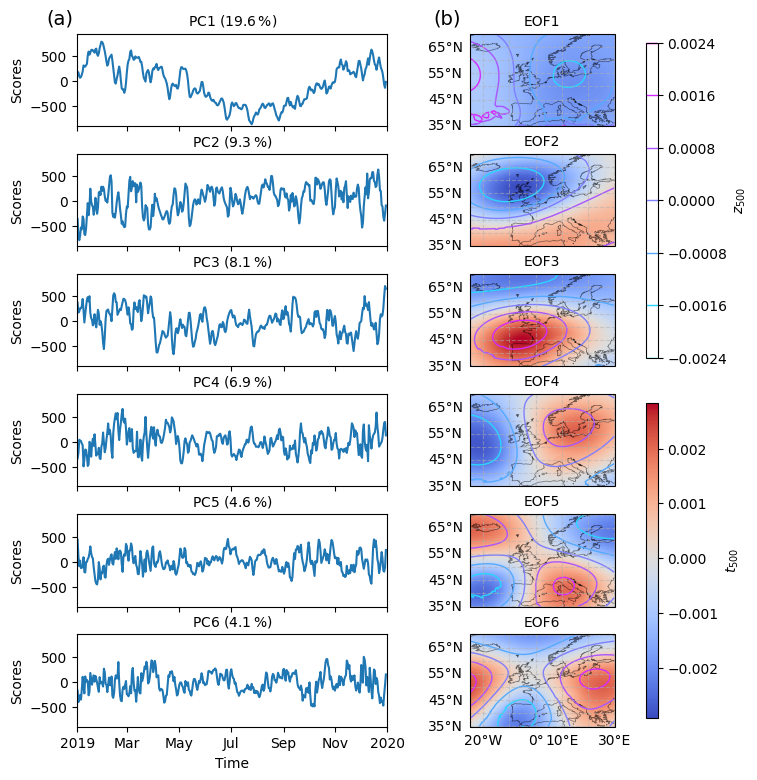

In [110]:
%%time
import cartopy.crs as ccrs
import datetime


def round_to_decade(value: xr.DataArray) -> int:
    return int(np.round(value.values, -1))


levels = list(
    range(
        round_to_decade(pcs_field_z_min),
        round_to_decade(pcs_field_z_max),
        5,
    )
)

n_pcs = 6
n_rows = n_pcs
n_cols = 2

fig = plt.figure(figsize=(4 * n_cols, 1.5 * n_rows))
gs = fig.add_gridspec(n_rows, n_cols)

# axs_left = fig.add_subplot(gs[:, 0], projection=ccrs.PlateCarree())

for i, (pc_field_t, pc_field_z, pc_scores) in enumerate(pcs_props.values()):
    ax_left = fig.add_subplot(gs[i, 1], projection=ccrs.PlateCarree())

    heatmap = pc_field_t.plot(
        ax=ax_left,
        cmap="coolwarm",
        vmin=pcs_field_t_min,
        vmax=pcs_field_t_max,
        add_colorbar=False,
    )
    contours = pc_field_z.plot.contour(
        ax=ax_left,
        # levels=levels,
        cmap="cool",
        transform=ccrs.PlateCarree(),
        linewidths=1.0,
    )
    ax_left.coastlines(alpha=0.5, linewidth=0.5)

    draw_labels = ["left"] if i < 5 else ["left", "bottom"]
    ax_left.gridlines(
        draw_labels=draw_labels,
        crs=ccrs.PlateCarree(),
        alpha=0.5,
        linestyle="--",
    )
    ax_left.set_title(f"EOF{i+1}", fontsize=10)

    ax_right = fig.add_subplot(gs[i, 0])

    pc_scores.sel(
        time=slice(
            datetime.datetime(2019, 1, 1), datetime.datetime(2019, 12, 31)
        )
    ).plot.line(ax=ax_right)

    if i < n_pcs - 1:
        ax_right.set_xticklabels([])
        ax_right.set_xlabel(None)
    else:
        ax_right.set_xlabel("Time")

    ax_right.set_ylim(-900, 950)

    xticks = ax_right.get_xticks()
    ax_right.set_xlim(xticks[0], xticks[-1])
    ax_right.set_ylabel("Scores")
    ax_right.set_title(
        rf"PC{i+1} (${pca.explained_variance_ratio_[i] * 100.0:.1f}\,\%$)",
        fontsize=10,
    )

    if i == 0:
        fontsize = 14
        ax_left.annotate(
            "(b)",
            xy=(-0.25, 1.1),
            xycoords="axes fraction",
            fontsize=fontsize,
        )
        ax_right.annotate(
            "(a)", xy=(-0.1, 1.1), xycoords="axes fraction", fontsize=fontsize
        )

bar_h = 0.35
pos_top = ax_left.get_position()
ax_cbar1 = fig.add_axes([pos_top.x1 + 0.015, 0.52, 0.015, bar_h])
cbar1 = fig.colorbar(
    contours, cax=ax_cbar1, orientation="vertical", label=r"$z_{500}$"
)
ax_cbar2 = fig.add_axes([pos_top.x1 + 0.015, 0.12, 0.015, bar_h])
cbar2 = fig.colorbar(
    heatmap, cax=ax_cbar2, orientation="vertical", label=r"$t_{500}$"
)

plt.subplots_adjust(wspace=0, hspace=0.3)

fig.savefig(plots / "eofs-pc-scores.png", dpi=300, bbox_inches="tight")

# fig.tight_layout()

## Comparison plots for samples closest to the cluster centroids

In [159]:
kmeans_pca_30 = joblib.load(kmeans_dir / "kmeans_pca_n_pcs_6_k_30.joblib")
pca_transformed = joblib.load(pca_dir / "pca_6_pcs_transformed.joblib")
pca_transformed.shape

(21826, 6)

In [160]:
import torch

device = torch.device("cpu")

head = 0
assignments = torch.load(
    f"/p/project1/deepacf/emmerich1/dcv2/multi-level-all-fields-1964-2023-1200-epochs-k-{dcv2_k}/epoch-799-assignments.pt",
    map_location=device,
)[head]
distances = torch.load(
    f"/p/project1/deepacf/emmerich1/dcv2/multi-level-all-fields-1964-2023-1200-epochs-k-{dcv2_k}/epoch-799-distances.pt",
    map_location=device,
)[head]

closest_sample_dates_dcv2 = []

for k in range(dcv2_k):
    samples_idxs = torch.argwhere(assignments == k)
    distances_samples = distances[samples_idxs]
    closest_sample_idx_samples_idxs = torch.argmin(distances_samples)
    closest_sample_idx = samples_idxs[closest_sample_idx_samples_idxs]
    date = ds.isel({coordinates.time: closest_sample_idx})[
        coordinates.time
    ].values[0]
    closest_sample_dates_dcv2.append(date)

print(closest_sample_dates_dcv2)

[numpy.datetime64('2021-04-05T12:00:00.000000000'), numpy.datetime64('2023-04-16T12:00:00.000000000'), numpy.datetime64('1976-10-23T12:00:00.000000000'), numpy.datetime64('1967-10-03T12:00:00.000000000'), numpy.datetime64('1964-11-04T12:00:00.000000000'), numpy.datetime64('1992-05-08T12:00:00.000000000'), numpy.datetime64('1999-02-14T12:00:00.000000000'), numpy.datetime64('1982-06-09T12:00:00.000000000'), numpy.datetime64('1965-06-09T12:00:00.000000000'), numpy.datetime64('1970-08-02T12:00:00.000000000'), numpy.datetime64('1977-10-09T12:00:00.000000000'), numpy.datetime64('2019-06-13T12:00:00.000000000'), numpy.datetime64('2004-03-13T12:00:00.000000000'), numpy.datetime64('2007-06-19T12:00:00.000000000')]


In [161]:
def get_samples_closest_to_centroids(kmeans) -> list[np.datetime64]:
    from scipy.spatial.distance import euclidean

    closest_sample_dates = []
    for iclust in range(kmeans.n_clusters):
        cluster_samples = pca_transformed[kmeans.labels_ == iclust]
        cluster_samples_indices = np.where(kmeans.labels_ == iclust)[0]

        cluster_cen = kmeans.cluster_centers_[iclust]
        min_idx = np.argmin(
            [
                euclidean(pca_transformed[idx], cluster_cen)
                for idx in cluster_samples_indices
            ]
        )

        # print('closest point to cluster center: ', cluster_samples[min_idx])
        # print('closest index of point to cluster center: ', cluster_samples_indices[min_idx])
        # print('  ', pca_transformed[cluster_samples_indices[min_idx]])
        closest_sample_idx = cluster_samples_indices[min_idx]
        date = ds.isel({coordinates.time: closest_sample_idx})[
            coordinates.time
        ].values
        closest_sample_dates.append(date)

    return closest_sample_dates


closest_sample_dates_pca = get_samples_closest_to_centroids(kmeans_pca_30)
print(closest_sample_dates_pca)

[numpy.datetime64('1992-10-30T12:00:00.000000000'), numpy.datetime64('1994-06-26T12:00:00.000000000'), numpy.datetime64('2002-04-16T12:00:00.000000000'), numpy.datetime64('1982-11-24T12:00:00.000000000'), numpy.datetime64('1975-03-19T12:00:00.000000000'), numpy.datetime64('2020-11-22T12:00:00.000000000'), numpy.datetime64('1970-12-04T12:00:00.000000000'), numpy.datetime64('1973-03-31T12:00:00.000000000'), numpy.datetime64('2006-01-21T12:00:00.000000000'), numpy.datetime64('2000-09-14T12:00:00.000000000'), numpy.datetime64('1964-01-05T12:00:00.000000000'), numpy.datetime64('2006-09-25T12:00:00.000000000'), numpy.datetime64('1988-01-26T12:00:00.000000000'), numpy.datetime64('1972-11-15T12:00:00.000000000'), numpy.datetime64('2005-03-15T12:00:00.000000000'), numpy.datetime64('1976-08-03T12:00:00.000000000'), numpy.datetime64('2014-01-14T12:00:00.000000000'), numpy.datetime64('2011-10-23T12:00:00.000000000'), numpy.datetime64('1997-06-04T12:00:00.000000000'), numpy.datetime64('1985-03-07T1

CPU times: user 15.9 s, sys: 10 s, total: 25.9 s
Wall time: 20.2 s


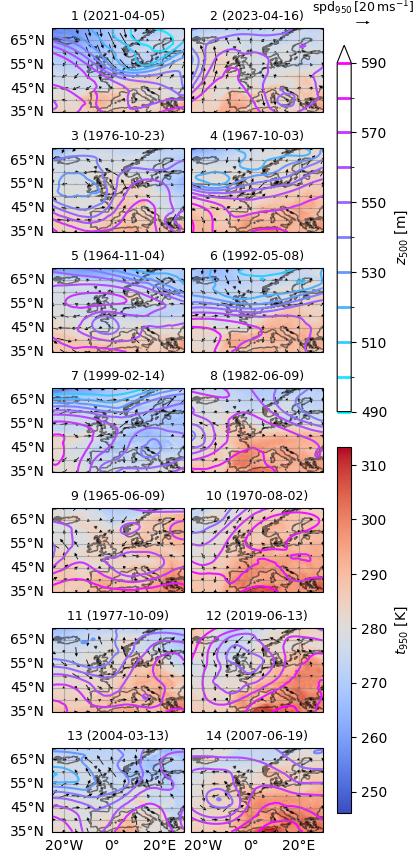

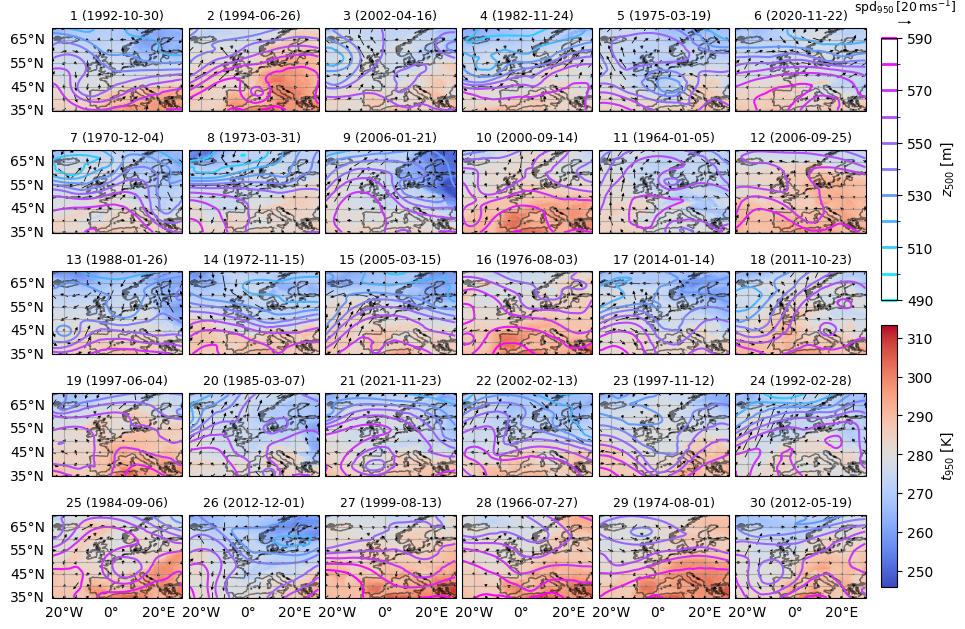

In [164]:
%%time

import matplotlib.ticker as mticker


def round_to_decade(value: xr.DataArray) -> int:
    return int(np.round(value.values, -1))


sub_with_zh = (
    a6.datasets.methods.select.select_levels(levels=[500, 950])
    >> a6.features.methods.geopotential.calculate_geopotential_height()
).apply_to(ds)

sub_with_zh_dates = sub_with_zh.sel(
    {coordinates.time: closest_sample_dates_dcv2 + closest_sample_dates_pca}
)

t_level = 950
t_dates = sub_with_zh_dates.sel({coordinates.level: t_level})[variables.t]
t_max = t_dates.max()
t_min = t_dates.min()

z_level = 500
z_dates = sub_with_zh_dates.sel({coordinates.level: z_level})[
    variables.geopotential_height
]
z_max = z_dates.max()
z_min = z_dates.min()
z_steps = 10
levels = range(
    round_to_decade(z_min),
    round_to_decade(z_max),
    z_steps,
)

uv_level = 950
uv_steps = 20
skip = slice(None, None, uv_steps)


def plot_comparison(sub: xr.Dataset, dates: list[np.datetime64], name: str):
    sub = sub.sel({coordinates.time: dates})
    t = sub.sel({coordinates.level: t_level})[variables.t]
    z = sub.sel({coordinates.level: z_level})[variables.geopotential_height]
    uv = sub.sel(
        {
            coordinates.level: uv_level,
            coordinates.longitude: skip,
            coordinates.latitude: skip,
        }
    )

    if name == "dcv2":
        ncols = 2
        nrows = 7
    else:
        ncols = 6
        nrows = 5

    height = nrows * 1.5
    width = ncols * 1.75

    fig, axs = plt.subplots(
        figsize=(width, height),
        nrows=nrows,
        ncols=ncols,
        subplot_kw={"projection": ccrs.PlateCarree()},
    )

    for i, (ax, date) in enumerate(zip(axs.flatten(), dates, strict=True)):
        # Plot temperature at 950 hPa
        heatmap = t.sel({coordinates.time: date}).plot(
            ax=ax,
            cmap="coolwarm",
            vmin=t_min,
            vmax=t_max,
            add_colorbar=False,
        )

        # Plot geopotential height contours
        contours = z.sel({coordinates.time: date}).plot.contour(
            ax=ax,
            transform=ccrs.PlateCarree(),
            levels=levels,
            cmap="cool",
        )
        # contours.clabel(inline=True)

        # Plot wind speed
        quiver = uv.sel({coordinates.time: date}).plot.quiver(
            ax=ax,
            x=coordinates.longitude,
            y=coordinates.latitude,
            u=variables.u,
            v=variables.v,
            scale=200,
            headlength=4,
            headwidth=4,
            add_guide=False,
        )

        # Draw legend for quiver
        if i == (ncols - 1):
            uv_legend_ms = 20
            qv_key = ax.quiverkey(
                quiver,
                1.3,
                1.065,
                uv_legend_ms,
                rf"spd$_{{{uv_level}}}\,\left[{uv_legend_ms}\,\mathrm{{m}}\mathrm{{s}}^{{-1}}\right]$",
                labelpos="N",
                labelsep=0.05,
                fontproperties=dict(size=9),
            )

        ax.coastlines(alpha=0.5)

        left_corner_index = (ncols * nrows) - ncols

        grid_kwargs = dict(
            crs=ccrs.PlateCarree(),
            color="gray",
            alpha=0.5,
            xlabel_style={"rotation": 0},
            xlocs=[-20, 0, 20],
            # linestyle="--",
        )
        if i in list(range(0, 99, ncols)):
            if i == left_corner_index:
                ax.gridlines(draw_labels=["left", "bottom"], **grid_kwargs)
            elif i < left_corner_index:
                ax.gridlines(draw_labels=["left"], **grid_kwargs)
        elif i > left_corner_index:
            ax.gridlines(draw_labels=["bottom"], **grid_kwargs)
        else:
            ax.gridlines(draw_labels=False, **grid_kwargs)

        lswr_name = f"{i + 1}" if name != "GWL" else gwl_labels_map[i + 1]
        ax.set_title(
            f"{lswr_name} ({np.datetime_as_string(date, unit='D')})", fontsize=9
        )

    plt.subplots_adjust(wspace=0.05, hspace=0.35)

    if name == "GWL":
        frac = 0.015
        bar_h = 0.3575
        y_top = 0.51
        y_bot = 0.125
    elif name == "dcv2":
        frac = 0.04
        bar_h = 0.349
        y_top = 0.5125
        y_bot = 0.13
    else:
        frac = 0.015
        bar_h = 0.349
        y_top = 0.5125
        y_bot = 0.13

    pos_top = axs[0][-1].get_position()
    ax_cbar1 = fig.add_axes([pos_top.x1 + frac, y_top, frac, bar_h])
    cbar1 = fig.colorbar(
        contours,
        cax=ax_cbar1,
        orientation="vertical",
        label=rf"$z_{{{z_level}}}$ [m]",
    )
    cbar1.lines[0].set_linewidth(2.0)
    ax_cbar2 = fig.add_axes([pos_top.x1 + frac, y_bot, frac, bar_h])
    cbar2 = fig.colorbar(
        heatmap,
        cax=ax_cbar2,
        orientation="vertical",
        label=rf"$t_{{{t_level}}}$ [K]",
    )

    fig.savefig(plots / f"comparison-{name}.png", dpi=300, bbox_inches="tight")


for name, dates in [
    ("dcv2", closest_sample_dates_dcv2),
    ("pca", closest_sample_dates_pca),
]:
    plot_comparison(sub=sub_with_zh, dates=dates, name=name)

## LSWR abundances

In [154]:
import pandas as pd

labels_and_counts = [
    np.unique(element, return_counts=True) for element in lswrs
]

sum_counts = [sum(c) for _, c in labels_and_counts]

counts_and_percentage = [
    (labels, counts, (counts / sum_count) * 100.0)
    for (labels, counts), sum_count in zip(labels_and_counts, sum_counts)
]
# for label, counts, percentage in counts_and_percentage:
#     print("label", "total", "relative")
#     for l, c, p in zip(label, counts, percentage):
#         print(l, c, f"{p:.1f} %")

print("label", 3 * "\ttotal\trelative")
for i in range(40):

    def _get_values(p):
        try:
            _, counts, percentage = p
            return f"{counts[i]}", f"{percentage[i]:.1f} %"
        except IndexError:
            return "    ", "   "

    a = "\t".join(
        _get_values(counts_and_percentage[0])
        + ("\t",)
        + _get_values(counts_and_percentage[1])
        + ("\t",)
        + _get_values(counts_and_percentage[2])
    )
    print(i + 1, "\t", a)

label 	total	relative	total	relative	total	relative
1 	 5416	24.8 %			626	2.9 %			856	5.4 %
2 	 870	4.0 %			1132	5.2 %			560	3.5 %
3 	 1715	7.9 %			606	2.8 %			129	0.8 %
4 	 2871	13.2 %			704	3.2 %			716	4.5 %
5 	 1395	6.4 %			612	2.8 %			1391	8.8 %
6 	 1931	8.8 %			675	3.1 %			470	3.0 %
7 	 897	4.1 %			591	2.7 %			93	0.6 %
8 	 837	3.8 %			626	2.9 %			47	0.3 %
9 	 1006	4.6 %			695	3.2 %			1454	9.2 %
10 	 329	1.5 %			1014	4.6 %			1201	7.6 %
11 	 747	3.4 %			588	2.7 %			385	2.4 %
12 	 789	3.6 %			872	4.0 %			391	2.5 %
13 	 2041	9.4 %			607	2.8 %			56	0.4 %
14 	 982	4.5 %			694	3.2 %			656	4.2 %
15 	     	   			573	2.6 %			1402	8.9 %
16 	     	   			964	4.4 %			133	0.8 %
17 	     	   			578	2.6 %			21	0.1 %
18 	     	   			665	3.0 %			11	0.1 %
19 	     	   			697	3.2 %			519	3.3 %
20 	     	   			669	3.1 %			219	1.4 %
21 	     	   			551	2.5 %			173	1.1 %
22 	     	   			514	2.4 %			17	0.1 %
23 	     	   			643	2.9 %			145	0.9 %
24 	     	   			598	2.7 %			184	1.2 %
25 	     	   			943	4.

[   0. 2000. 4000. 6000.]
[   0.  250.  500.  750. 1000. 1250.]
[   0.  500. 1000. 1500. 2000.]


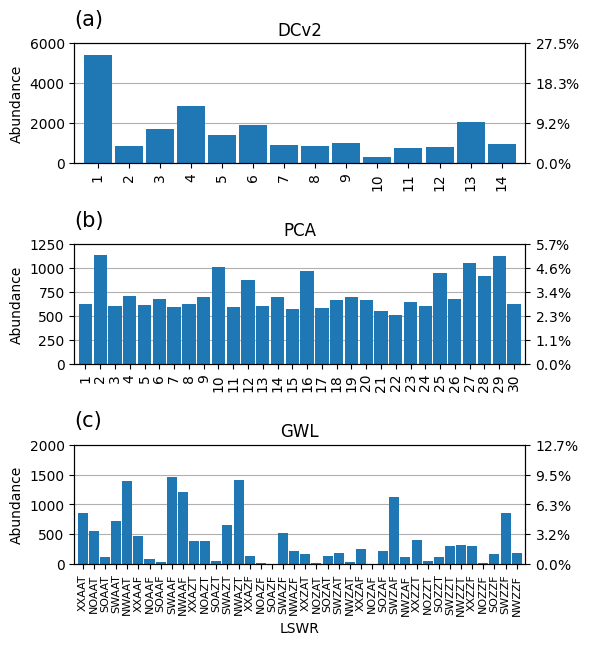

In [155]:
def plot_abundance(
    assignments: list[xr.DataArray],
) -> None:
    n_subplots = len(assignments)

    fig, axs = plt.subplots(
        figsize=(6, 2.2 * n_subplots),
        nrows=n_subplots,
        ncols=1,
        # sharey=True,
    )

    # plt.title(f"Abundance of LSWRs")

    labels_and_counts = [
        np.unique(element, return_counts=True) for element in assignments
    ]
    max_sum_counts = max(sum(counts) for _, counts in labels_and_counts)

    for i, (labels, counts) in enumerate(labels_and_counts):
        # colors = _colors.create_colors_for_labels(labels)
        xlims = labels.min() - 0.75, labels.max() + 0.75

        ax = axs[i]
        ax.bar(
            x=labels,
            height=counts,
            # color=colors,
            width=0.9,
        )

        ylim = (0, 6000)

        ax.set(
            title=assignments[i].name,
            ylabel="Abundance",
            xlim=xlims,
            # ylim=ylim,
        )

        if i == n_subplots - 1:
            ax.set_xlabel("LSWR")

        ax.set_xticks(labels)

        if i == 2:
            ax.set_xticklabels(gwl_labels, rotation=90, fontsize=8)
        else:
            ax.set_xticklabels(labels, rotation=90)

        yticks = [0, 500, 1000, 1500, 2000, 2500]
        # ax.set_yticks(yticks)
        yticks = ax.get_yticks()
        print(yticks)

        ax.yaxis.grid(True)

        ax_right = ax.twinx()
        ylim = ax.get_ylim()
        ax.set_ylim(*ylim)
        ax.set_yticks(yticks)
        ax.set_yticklabels([f"{t:.0f}" for t in yticks])
        ax_right.set_ylim(*ylim)
        percentage_ticks = yticks / sum(counts)
        ax_right.set_yticks(yticks)
        ax_right.set_yticklabels(
            [f"${tick * 100:.1f}\%$" for tick in percentage_ticks]
        )

        ax.annotate(
            f"({alphabet[i]})",
            xy=(0.0, 1.15),
            xycoords="axes fraction",
            fontsize=15,
        )

    fig.tight_layout()
    fig.savefig(plots / "lswrs-abundance-comparison.pdf", bbox_inches="tight")


plot_abundance(lswrs)

## Transition probabilities

In [11]:
%%time

transition_probabilites = [
    a6.plotting.transitions._calculate_markov_transition_matrix(lswr)
    for lswr in lswrs
]

/opt/a6/src/a6/plotting/transitions.py:73: RuntimeWarning: invalid value encountered in divide
  as_probabilities = matrix / matrix.sum(axis=1, keepdims=True)
/opt/a6/src/a6/plotting/transitions.py:73: RuntimeWarning: invalid value encountered in divide
  as_probabilities = matrix / matrix.sum(axis=1, keepdims=True)


CPU times: user 1min 12s, sys: 6.14 ms, total: 1min 12s
Wall time: 1min 12s


/opt/a6/src/a6/plotting/transitions.py:73: RuntimeWarning: invalid value encountered in divide
  as_probabilities = matrix / matrix.sum(axis=1, keepdims=True)


In [12]:
transitions = [
    np.delete(np.delete(t, (0), axis=1), (0), axis=0)
    for t in transition_probabilites
]

CPU times: user 1.85 s, sys: 427 ms, total: 2.28 s
Wall time: 1.62 s


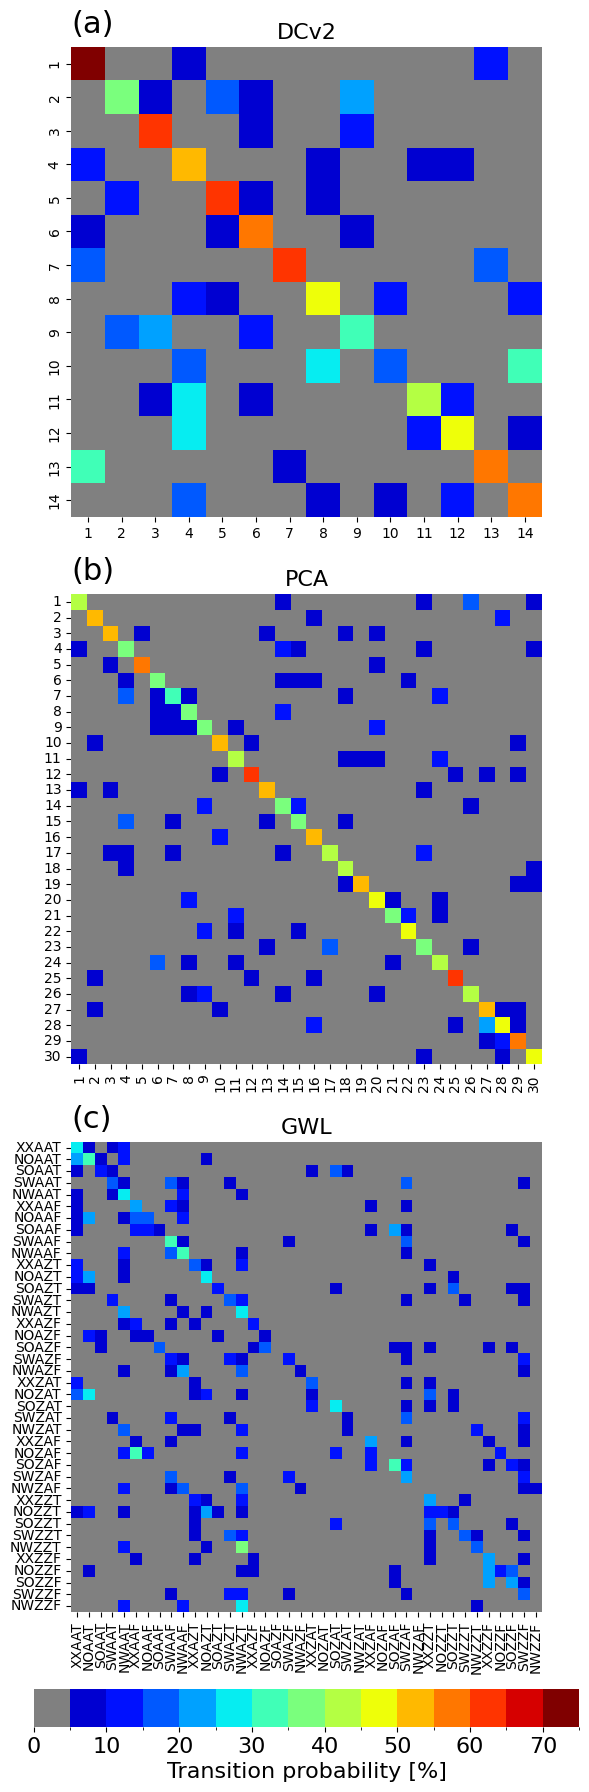

In [156]:
%%time

import seaborn as sns
import itertools

import matplotlib.colors
import matplotlib as mpl


def plot_transition_matrix_heatmap(
    assignments: list[xr.DataArray], transitions: list[np.ndarray]
) -> None:
    n_subplots = len(assignments)
    height_ratios = [1 for _ in enumerate(assignments)] + [0.08]

    # Add 1 subplot just for the colorbar
    fig, axs = plt.subplots(
        figsize=(6, 6 * n_subplots),
        ncols=1,
        nrows=n_subplots + 1,
        gridspec_kw={"height_ratios": height_ratios},
    )

    axs_cbar = axs[-1]

    max_prob = max(t.max() * 100.0 for t in transitions)
    min_prob = min(t.min() * 100.0 for t in transitions)

    cmap = plt.cm.jet  # define the colormap
    # extract all colors from the .jet map
    cmaplist = [cmap(i) for i in range(cmap.N)]
    # force the first color entry to be grey
    cmaplist[0] = (0.5, 0.5, 0.5, 1.0)

    # create the new map
    cmap = mpl.colors.LinearSegmentedColormap.from_list(
        "Custom cmap", cmaplist, cmap.N
    )

    # define the bins and normalize
    bounds = np.arange(0, 80, 5)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

    fontsize = 16

    for i, element in enumerate(assignments):
        transition = transitions[i] * 100.0
        kwargs = (
            {"cbar": False}
            if i < n_subplots - 1
            else {
                "cbar_ax": axs_cbar,
                "cbar_kws": {
                    "label": "Transition probability [%]",
                    "orientation": "horizontal",
                    "cmap": cmap,
                    "norm": norm,
                    # ticks=bounds,
                    "boundaries": bounds,
                },
            }
        )
        ax = axs[i]

        xticklabels = (
            list(range(1, transition.shape[0] + 1)) if i != 2 else gwl_labels
        )
        yticklabels = (
            list(range(1, transition.shape[0] + 1)) if i != 2 else gwl_labels
        )
        ax = sns.heatmap(
            transition,
            ax=ax,
            cmap=cmap,
            norm=norm,
            square=True,
            # norm=matplotlib.colors.LogNorm(),
            xticklabels=xticklabels,
            yticklabels=yticklabels,
            **kwargs,
        )
        ax.set_title(element.name, fontsize=fontsize)

        ax.annotate(
            f"({alphabet[i]})",
            xy=(0.0, 1.03),
            xycoords="axes fraction",
            fontsize=22,
        )

    axs_cbar.tick_params(labelsize=fontsize)
    axs_cbar.xaxis.label.set_size(fontsize)
    axs_cbar.yaxis.label.set_size(fontsize)

    fig.tight_layout()
    fig.savefig(
        plots / "lswrs-transition-probabilities-comparison.pdf",
        bbox_inches="tight",
    )


plot_transition_matrix_heatmap(lswrs, transitions=transitions)

## LSWR durations

label mean	median	95-quantile		mean	median	95-quantile		mean	median	95-quantile		
1 	 3.7	2	13			1.7	1	4			1.3	1	3
2 	 1.6	1	4			2.2	2	5			1.4	1	3
3 	 2.8	2	8			2.1	2	6			1.2	1	2
4 	 2.1	1	5			1.6	1	4			1.2	1	2
5 	 2.7	2	6			2.4	2	6			1.4	1	3
6 	 2.4	2	6			1.6	1	4			1.3	1	3
7 	 2.7	2	7			1.4	1	3			1.2	1	2
8 	 1.8	1	4			1.6	1	4			1.1	1	2
9 	 1.5	1	4			1.6	1	4			1.5	1	3
10 	 1.2	1	2			2.2	2	5			1.5	1	3
11 	 1.7	1	4			1.8	1	4			1.2	1	2
12 	 2.0	1	5			2.5	2	7			1.4	1	3
13 	 2.4	1	7			2.2	1	6			1.1	1	2
14 	 2.3	2	6			1.6	1	4			1.2	1	2
15 	    	 	  			1.6	1	3			1.4	1	3
16 	    	 	  			2.2	2	6			1.1	1	2
17 	    	 	  			1.8	1	4			1.1	1	2
18 	    	 	  			1.8	1	4			1.0	1	1
19 	    	 	  			2.0	2	5			1.1	1	2
20 	    	 	  			1.9	1	4			1.1	1	2
21 	    	 	  			1.6	1	3			1.2	1	2
22 	    	 	  			1.8	1	4			1.0	1	1
23 	    	 	  			1.7	1	4			1.4	1	3
24 	    	 	  			1.7	1	4			1.1	1	2
25 	    	 	  			2.7	2	7			1.0	1	1
26 	    	 	  			1.8	1	4			1.3	1	2
27 	    	 	  			2.0	2	5			1.0	1	1
28 	    	 	  			1.8	1	

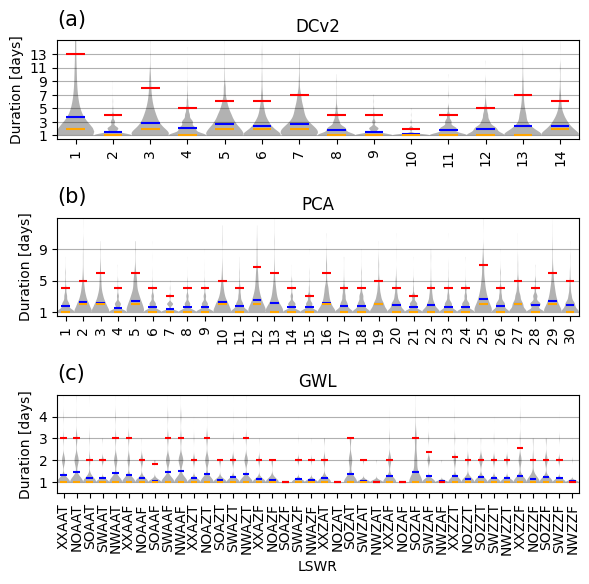

In [157]:
def plot_modes_durations(
    assignments: list[xr.DataArray],
) -> tuple[plt.Figure, plt.Axes]:
    """Plot the mode mean durations and standard deviation."""
    n_subplots = len(assignments)
    modes = [
        a6.modes.methods.determine_lifetimes_of_modes(a) for a in assignments
    ]

    fig, axs = plt.subplots(
        figsize=(6, 2 * n_subplots),
        nrows=n_subplots,
        ncols=1,
        # sharex=True,
        # sharey=True,
    )

    paths = []

    for i, element in enumerate(modes):
        labels = np.arange(1, element.size + 1, 1, dtype=int)

        x_lims = labels.min() - 0.5, labels.max() + 0.5
        colors = _colors.create_colors_for_labels(labels)
        name = assignments[i].name

        durations = [
            [appearance.duration.days for appearance in e.appearances]
            for e in element
        ]
        ax = axs[i]
        parts = ax.violinplot(
            durations,
            widths=1,
            showmeans=True,
            showmedians=True,
            showextrema=False,
            quantiles=[[0.95] for _ in enumerate(durations)],
        )

        parts["cmeans"].set_color("blue")
        parts["cmedians"].set_color("orange")
        # parts["cmins"].set_alpha(0.0)
        # parts["cmaxes"].set_color("red")
        # parts["cbars"].set_alpha(0.0)
        parts["cquantiles"].set_color("red")

        # print(parts["cmeans"].__dict__)

        paths.append(
            list(
                zip(
                    parts["cmeans"]._paths,
                    parts["cmedians"]._paths,
                    parts["cquantiles"]._paths,
                )
            )
        )

        for color, pc in zip(colors, parts["bodies"]):
            pc.set_facecolor("black")
            # pc.set_edgecolor(color)
            pc.set_alpha(0.3)

        ax.set_title(name)

        if i == n_subplots - 1:
            axs[i].set_xlabel("LSWR")

        ax.set_ylabel("Duration [days]")
        ax.set_xlim(*x_lims)
        ax.set_xticks(labels)
        labels = labels if i != 2 else gwl_labels
        ax.set_xticklabels(labels, rotation=90)
        ax.yaxis.grid(True)

        if i == 2:
            ylim = (0.5, 5)
            yticks = list(range(1, ylim[1]))
        elif i == 1:
            ylim = (0.5, 13)
            yticks = list(range(1, ylim[1], 4))
        else:
            ylim = (0.5, 15)
            yticks = list(range(1, ylim[1], 2))

        ax.set_ylim(*ylim)
        ax.set_yticks(yticks)

        ax.annotate(
            f"({alphabet[i]})",
            xy=(0.0, 1.15),
            xycoords="axes fraction",
            fontsize=15,
        )

    fig.tight_layout()
    fig.savefig(plots / "lswrs-durations-comparison.pdf", bbox_inches="tight")

    print("label", 3 * "mean\tmedian\t95-quantile\t\t")
    for i in range(40):

        def _get_values(p):
            try:
                mean, median, quantile = p[i]
                return (
                    f"{mean._vertices[0][-1]:.1f}",
                    f"{median._vertices[0][-1]:.0f}",
                    f"{quantile._vertices[0][-1]:.0f}",
                )
            except IndexError:
                return "   ", " ", "  "

        a = "\t".join(
            _get_values(paths[0])
            + ("\t",)
            + _get_values(paths[1])
            + ("\t",)
            + _get_values(paths[2])
        )
        print(i + 1, "\t", a)


plot_modes_durations(lswrs)

In [79]:
maxs = [
    [
        (i, regime.statistics.duration.max.days)
        for i, regime in enumerate(
            a6.modes.methods.determine_lifetimes_of_modes(series)
        )
    ]
    for series in lswrs
]

print("label\tDCv2\tPCA\tGWL")
for i in range(40):

    def _get_values(p):
        try:
            _, max_ = p[i]
            return (f"{max_}",)
        except IndexError:
            return ("   ",)

    a = "\t".join(
        _get_values(maxs[0]) + _get_values(maxs[1]) + _get_values(maxs[2])
    )
    print(i + 1, "\t", a)

label	DCv2	PCA	GWL
1 	 54	8	6
2 	 9	13	5
3 	 17	10	5
4 	 14	7	3
5 	 15	10	9
6 	 17	10	6
7 	 18	5	3
8 	 10	8	2
9 	 7	9	7
10 	 5	12	6
11 	 10	8	4
12 	 12	12	5
13 	 16	14	2
14 	 16	7	5
15 	    	9	8
16 	    	11	3
17 	    	8	2
18 	    	9	1
19 	    	10	4
20 	    	11	3
21 	    	8	3
22 	    	9	1
23 	    	11	3
24 	    	8	2
25 	    	16	2
26 	    	9	6
27 	    	11	1
28 	    	7	6
29 	    	14	4
30 	    	10	2
31 	    	   	5
32 	    	   	3
33 	    	   	3
34 	    	   	4
35 	    	   	3
36 	    	   	5
37 	    	   	3
38 	    	   	3
39 	    	   	5
40 	    	   	3


## Mean and standard deviation of $z_{500}$ for LSWRs

In [80]:
%%time


def calculate_mean_and_std(data: xr.Dataset, assignments: xr.DataArray):
    subset = (
        a6.datasets.methods.select.select_levels(levels=500)
        >> a6.features.methods.geopotential.calculate_geopotential_height()
    ).apply_to(data)

    total_mean = subset[variables.geopotential_height].mean("time")

    modes = a6.modes.methods.determine_lifetimes_of_modes(assignments)
    dates = [list(mode.get_dates()) for mode in modes]
    z_h_per_mode = [
        subset[variables.geopotential_height].sel(time=date, method="nearest")
        for date in dates
    ]

    means = [z_h.mean("time") - total_mean for z_h in z_h_per_mode]
    means_max = max(mean.max() for mean in means)
    means_min = min(mean.min() for mean in means)

    stds = [z_h.std("time") for z_h in z_h_per_mode]
    stds_max = max(std.max() for std in stds)
    stds_min = min(std.min() for std in stds)

    return (
        assignments.name,  # 0
        modes,  # 1
        means,  # 2
        means_min,  # 3
        means_max,  # 4
        stds,  # 5
        stds_min,  # 6
        stds_max,  # 7
    )


means_stds = [
    calculate_mean_and_std(data=ds, assignments=assignments)
    for assignments in lswrs
]

global_means_min = max(e[3] for e in means_stds)
global_means_max = max(e[4] for e in means_stds)
global_stds_min = max(e[6] for e in means_stds)
global_stds_max = max(e[7] for e in means_stds)

CPU times: user 31.6 s, sys: 15.6 s, total: 47.2 s
Wall time: 49.2 s


CPU times: user 15.3 s, sys: 5.51 s, total: 20.8 s
Wall time: 10.7 s


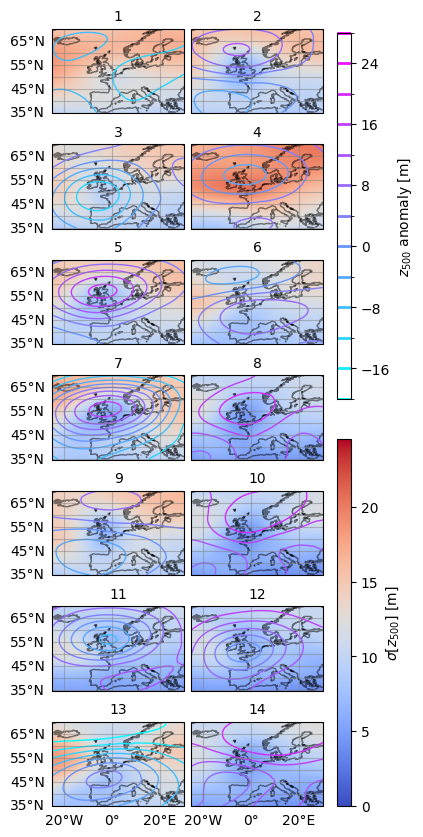

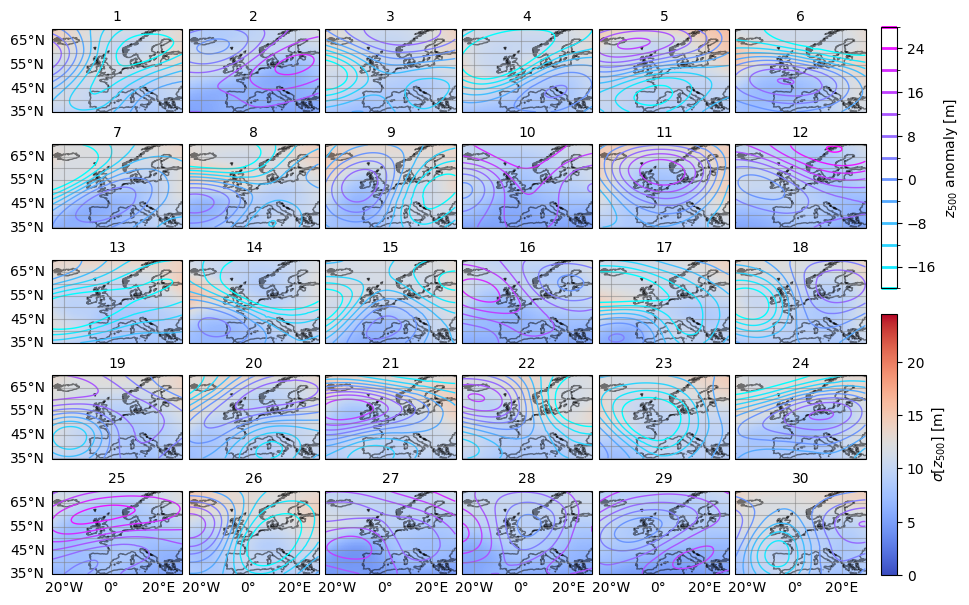

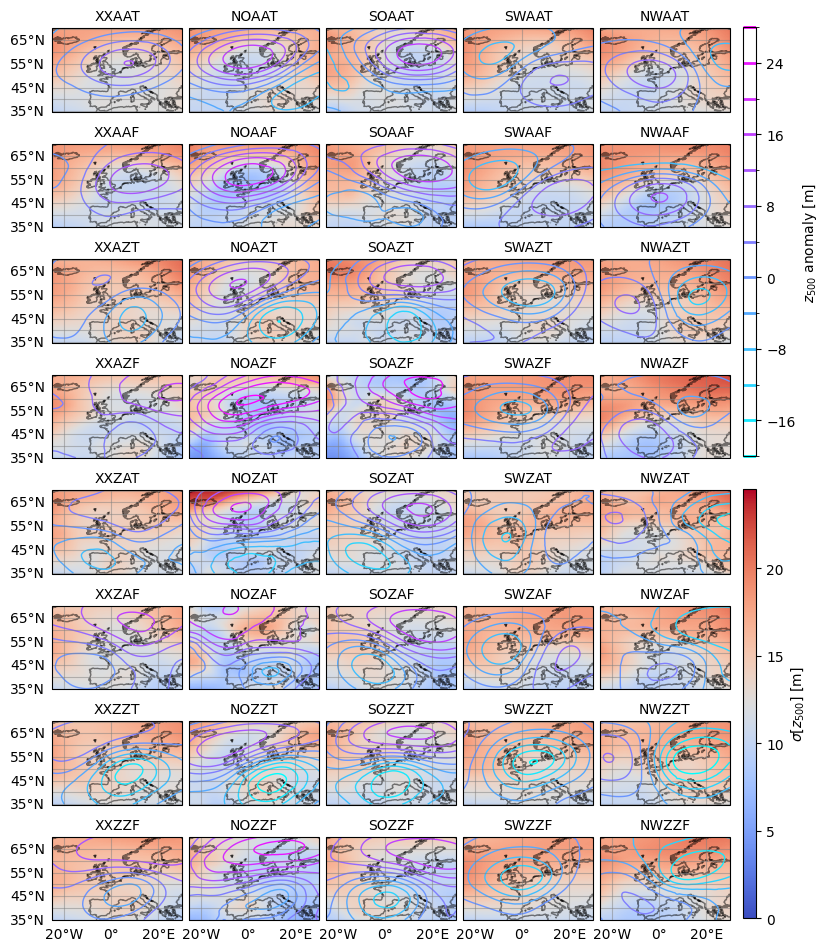

In [158]:
%%time
import cartopy.crs as ccrs


def round_to_decade(value: xr.DataArray) -> int:
    return int(np.round(value.values, -1))


def plot_geopotential_mean_and_std(
    name: str,
    modes,
    means: list[xr.DataArray],
    means_min: float,
    means_max: float,
    stds: list[xr.DataArray],
    stds_min: float,
    stds_max: float,
    global_means_min: float,
    global_means_max: float,
    global_stds_min: float,
    global_stds_max: float,
) -> tuple[plt.Figure, plt.Axes]:
    """Plot geopotential height anomalies, temperature and wind speed."""
    labels = np.arange(1, modes.size + 1, 1, dtype=int)

    if labels.max() == 40:
        nrows = 8
        ncols = 5
    elif labels.max() == 30:
        ncols = 6
        nrows = 5
    elif labels.max() == 14:
        ncols = 2
        nrows = 7

    if nrows * ncols != labels.max():
        raise ValueError("Number of plots not equal to number of LSWRs")

    height = nrows * 1.5
    width = ncols * 1.75

    fig, axs = plt.subplots(
        figsize=(width, height),
        nrows=nrows,
        ncols=ncols,
        subplot_kw=a6.plotting.coastlines.create_projection(),
    )
    levels = list(
        range(
            round_to_decade(global_means_min),
            round_to_decade(global_means_max),
            4,
        )
    )

    for i, ax in enumerate(axs.flatten()):
        z_h_mean = means[i]
        z_h_std = stds[i]
        heatmap = z_h_std.plot(
            ax=ax,
            cmap="coolwarm",
            vmin=min(global_stds_min, 0),
            vmax=global_stds_max,
            add_colorbar=False,
        )

        contours = z_h_mean.plot.contour(
            ax=ax,
            levels=levels,
            cmap="cool",
            transform=ccrs.PlateCarree(),
            linewidths=1.0,
        )
        # contours.clabel(inline=True)

        ax.coastlines(alpha=0.5)

        left_corner_index = (ncols * nrows) - ncols

        grid_kwargs = dict(
            crs=ccrs.PlateCarree(),
            color="gray",
            alpha=0.5,
            xlabel_style={"rotation": 0},
            xlocs=[-20, 0, 20],
            # linestyle="--",
        )
        if i in list(range(0, 99, ncols)):
            if i == left_corner_index:
                ax.gridlines(draw_labels=["left", "bottom"], **grid_kwargs)
            elif i < left_corner_index:
                ax.gridlines(draw_labels=["left"], **grid_kwargs)
        elif i > left_corner_index:
            ax.gridlines(draw_labels=["bottom"], **grid_kwargs)
        else:
            ax.gridlines(draw_labels=False, **grid_kwargs)

        title = f"{i + 1}" if name != "GWL" else gwl_labels_map[i + 1]
        ax.set_title(title, fontsize=10)

    plt.subplots_adjust(wspace=0.05, hspace=0.0)

    if name.lower() == "gwl":
        frac = 0.015
        bar_h = 0.3575
        y_top = 0.51
        y_bot = 0.125
    elif name.lower() == "dcv2":
        frac = 0.04
        bar_h = 0.349
        y_top = 0.5125
        y_bot = 0.125
    else:
        frac = 0.015
        bar_h = 0.349
        y_top = 0.5125
        y_bot = 0.13

    pos_top = axs[0][-1].get_position()
    ax_cbar1 = fig.add_axes([pos_top.x1 + frac, y_top, frac, bar_h])
    cbar1 = fig.colorbar(
        contours,
        cax=ax_cbar1,
        orientation="vertical",
        label=r"$z_{500}$ anomaly [m]",
    )
    cbar1.lines[0].set_linewidth(2.0)
    ax_cbar2 = fig.add_axes([pos_top.x1 + frac, y_bot, frac, bar_h])
    cbar2 = fig.colorbar(
        heatmap,
        cax=ax_cbar2,
        orientation="vertical",
        label=r"$\sigma\left[z_{500}\right]$ [m]",
    )

    fig.savefig(
        plots / f"lswrs-geopotential-heights-{name}.png",
        dpi=300,
        bbox_inches="tight",
    )


for mean_std in means_stds:
    plot_geopotential_mean_and_std(
        *mean_std,
        global_means_min=global_means_min,
        global_means_max=global_means_max,
        global_stds_min=global_stds_min,
        global_stds_max=global_stds_max,
    )

## Wind speed distributions

In [133]:
%%time


def flatten_wind_speeds(
    data: xr.Dataset, assignments: xr.DataArray
) -> dict[int, np.ndarray]:
    modes = a6.modes.methods.determine_lifetimes_of_modes(assignments)
    appearances = {mode.label: list(mode.get_dates()) for mode in modes}
    wind_speeds = {
        label: subset[variables.wind_speed]
        .sel(time=dates, method="nearest")
        .values.flatten()
        for label, dates in appearances.items()
    }
    return wind_speeds


subset = (
    a6.datasets.methods.select.select_levels(levels=950)
    >> a6.features.methods.wind.calculate_wind_speed()
).apply_to(ds)

wind_speeds: dict[str, dict[int, np.ndarray]] = {
    lswr.name: flatten_wind_speeds(data=subset, assignments=lswr)
    for lswr in lswrs
}

CPU times: user 12.3 s, sys: 8.4 s, total: 20.7 s
Wall time: 20.8 s


In [135]:
wind_speeds["GWL"][1].shape

(26673816,)

GWL
40 40
CPU times: user 2h 40min 35s, sys: 3h 17min 37s, total: 5h 58min 12s
Wall time: 21min 21s


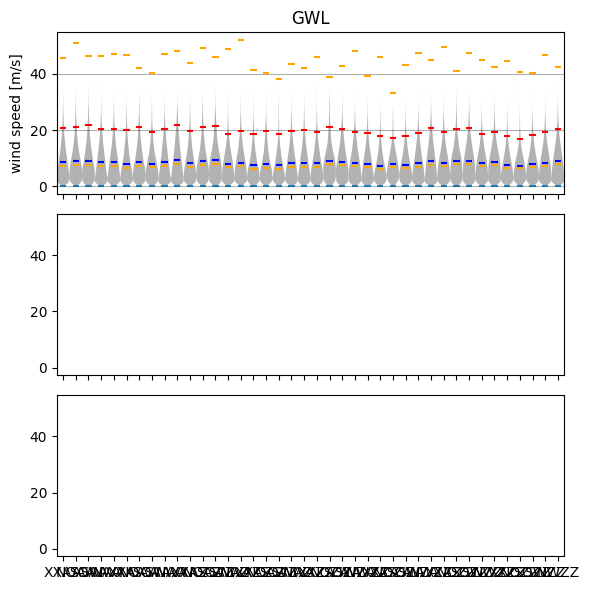

In [142]:
%%time


def plot_modes_wind_speed(
    wind_speeds_per_method: dict[str, dict[int, np.ndarray]]
) -> tuple[plt.Figure, plt.Axes]:
    """Plot the mode wind speeds."""
    n_subplots = len(wind_speeds_per_method)

    fig, axs = plt.subplots(
        figsize=(6, 2 * n_subplots),
        nrows=n_subplots,
        ncols=1,
        sharex=False,
        sharey=True,
    )

    for i, (name, wind_speeds) in enumerate(wind_speeds_per_method.items()):
        print(name)

        labels = list(wind_speeds.keys())
        x_lims = min(labels) - 0.5, max(labels) + 0.5
        colors = _colors.create_colors_for_labels(labels)

        ax = axs[i]

        parts = ax.violinplot(
            list(wind_speeds.values()),
            widths=1,
            showmeans=True,
            showmedians=True,
            showextrema=True,
            quantiles=[[0.95] for _ in enumerate(wind_speeds)],
        )

        parts["cmeans"].set_color("blue")
        parts["cmedians"].set_color("orange")
        # parts["cmins"].set_alpha(0.0)
        parts["cmaxes"].set_color("orange")
        parts["cbars"].set_alpha(0.0)
        parts["cquantiles"].set_color("red")

        for color, pc in zip(colors, parts["bodies"]):
            pc.set_facecolor("black")
            # pc.set_edgecolor(color)
            pc.set_alpha(0.3)

        for color, pc in zip(colors, parts["bodies"]):
            pc.set_facecolor("black")
            # pc.set_edgecolor(color)
            pc.set_alpha(0.3)

        ax.set_title(name)

        if i == n_subplots - 1:
            axs[i].set_xlabel("LSWR")

        ax.set_ylabel("spd [m/s]")
        ax.set_xlim(*x_lims)
        ax.set_xticks(labels)

        labels = labels if name != "GWL" else gwl_labels
        ax.set_xticklabels(labels, rotation=90)

        ax.yaxis.grid(True)
        break

    fig.tight_layout()
    plt.savefig(plots / "lswrs-wind-speed-comparison.pdf", bbox_inches="tight")


plot_modes_wind_speed(wind_speeds)